In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import datetime

from helper import make_alphas_state_matrix_with_day_step
from helper import instrument_return, merge_zeros
from helper import AlphaStats, calc_alphas_corr
from helper import normalize, neutralize, neutralize_with_dropout

import manipulate_alpha as mpa

from test import test1, test2, test3
from typing import NamedTuple

SLICE_INDEX = 2436

In [163]:
def decay (alpha_matrix, n): # decrease turnover
    
    factors = (np.arange(1, n + 2)) / (n+1)

    _new_alpha_states = alpha_matrix.copy()

    for idx in range(n+1, len(alpha_matrix)):
        _alpha = alpha_matrix[idx-n-1:idx] * np.array([factors]).T
        if not np.array_equal(_alpha, np.zeros_like(_alpha)):
            _new_alpha_states[idx] = _alpha.sum(axis=0)
    
    # return _alpha
    return _new_alpha_states 

In [3]:
class Alphas_Data(NamedTuple):
    name: str
    cumpnl: np.array

In [4]:
alphas = []

## Getting data and preparation

In [5]:
dataset_dir = './USA_2010-2014_HLOCV'
os.listdir(dataset_dir)

['Open.csv', 'High.csv', 'Close.csv', 'Low.csv', 'Volume.csv']

In [6]:
open_df = pd.read_csv(dataset_dir + '/Open.csv')
high_df = pd.read_csv(dataset_dir + '/High.csv')
close_df = pd.read_csv(dataset_dir + '/Close.csv')
low_df = pd.read_csv(dataset_dir + '/Low.csv')
volume_df = pd.read_csv(dataset_dir + '/Volume.csv')

In [7]:
open_df.shape

(2436, 1258)

In [8]:
high_df.head()

,Unnamed: 0,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,...,2014-12-17,2014-12-18,2014-12-19,2014-12-22,2014-12-23,2014-12-24,2014-12-26,2014-12-29,2014-12-30,2014-12-31
0,iba.us,20.9550,21.0930,21.4550,21.0930,21.0850,21.0930,20.7790,20.8300,20.8300,...,49.683,49.778,49.731,49.133,48.357,48.145,48.421,48.234,48.042,47.976
1,wpz.us,22.4110,22.6600,22.8230,22.6950,22.4190,22.4110,22.2410,22.0560,22.1830,...,39.784,40.744,39.883,41.540,42.894,42.722,42.205,41.560,41.353,40.770
2,flic.us,9.3094,9.2675,9.2492,9.2296,9.0356,9.3596,9.4185,9.3162,9.2361,...,16.666,16.895,17.277,16.950,17.494,17.184,17.767,18.020,18.093,17.767
3,ncs.us,10.2500,10.4000,10.4500,10.5000,11.7500,12.2000,11.2500,10.8500,10.7500,...,17.910,18.190,17.940,17.640,18.080,17.900,18.050,18.660,18.660,18.810
4,gpk.us,3.5531,3.6196,3.5243,3.5341,3.6006,3.4197,3.3814,3.3722,3.3814,...,12.613,12.917,12.956,13.023,13.164,13.222,13.383,13.421,13.281,13.232


In [9]:
low_df.head()

,Unnamed: 0,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,...,2014-12-17,2014-12-18,2014-12-19,2014-12-22,2014-12-23,2014-12-24,2014-12-26,2014-12-29,2014-12-30,2014-12-31
0,iba.us,20.2250,20.2590,20.4890,20.6740,20.6830,20.2170,19.9250,20.4890,20.4100,...,46.810,47.407,48.479,48.024,47.464,47.321,47.910,47.720,47.390,47.246
1,wpz.us,21.9210,22.1920,22.4110,22.1620,22.0760,22.0640,21.8470,21.3490,21.7000,...,37.739,38.869,38.781,38.861,40.905,41.775,41.209,40.770,40.421,40.073
2,flic.us,9.1839,9.1159,8.7931,8.7819,8.8440,8.8008,9.2400,9.1420,8.8335,...,15.603,16.290,16.802,15.882,16.685,16.653,16.931,17.193,17.012,17.116
3,ncs.us,9.2000,9.9500,10.0000,9.8500,10.2500,11.1500,10.4000,10.3000,10.4000,...,17.320,17.590,17.130,17.220,17.460,17.580,17.830,17.970,18.420,18.460
4,gpk.us,3.3722,3.4388,3.2958,3.2958,3.3624,3.2863,3.2863,3.2673,3.2958,...,12.288,12.660,12.756,12.782,13.013,13.097,13.183,13.222,13.136,12.966


In [10]:
alpha = np.random.rand(2,10)

true_false_vec = np.ones(alpha.shape)
true_false_vec[0][3:6] = 0
alpha[0][3:6] = 0
true_false_vec[1][4:7] = 0
alpha[1][4:7] = 0

alpha = normalize(neutralize_with_dropout(alpha, true_false_vec))

test1(alpha)
test2(alpha)

Neutrality test passed
Normality test passed


## The First strategy - reverse alpha
$\frac{close(d-n)}{close(d-1)}$

In [11]:
day_step = 6

In [12]:
def close_prices_ratio_alpha(df, start_date, end_date):
    return df[start_date] / df[end_date]

In [13]:
alpha_matrix1 = make_alphas_state_matrix_with_day_step(close_df, day_step, strategy=close_prices_ratio_alpha)

In [14]:
test1(alpha_matrix1[0])
test2(alpha_matrix1[day_step-1:]) # потому что альфы там просто нулевые

Neutrality test passed
Normality test passed


In [15]:
instrument_returns = instrument_return(close_df)
instrument_returns.shape

(1257, 2436)

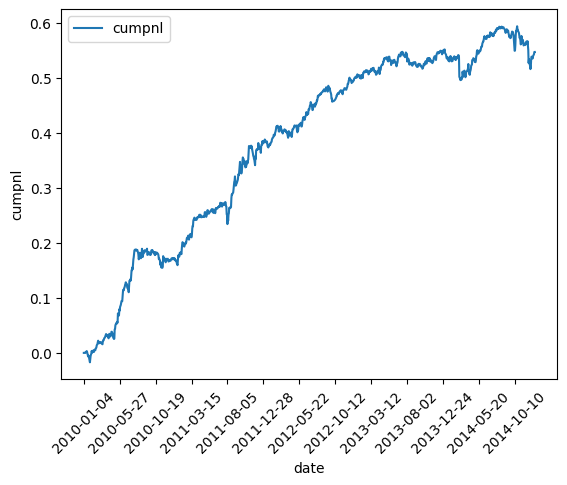

[0.17153272674624798, 0.3837789440431676, 0.4952046675107539, 0.5488982647991731, 0.5466361266412333]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,2.810019,0.640936,0.034603,0.171533
1,2011,2.868507,0.644960,0.040099,0.383779
2,2012,2.522248,0.637571,0.028996,0.495205
3,2013,1.203801,0.636768,0.030688,0.548898
4,2014,-0.030304,0.634479,0.077792,0.546636


In [16]:
alpha_1_data, alpha_1_cumpnl = AlphaStats(alpha_matrix1, close_df)
alpha_1_data.head()

In [17]:
test3(alpha_1_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [18]:
alphas.append(Alphas_Data('alpha1', alpha_1_cumpnl))

## The second strategy: Foma & French

$SMB - small minus big$

цена на маленькие компании растет быстрее, чем на большие,
сортируем акции по капитализации, больше капитализация - ставим в шорт,
меньше капитализация - в лонг.

Капитализация = кол-во акций (объем торгов) * цена акции

In [16]:
def make_SMB_alpha(close_df, volume_df, proportion=[33, 34, 33]):
    """
        Фама и Фенч предложили сортировать компании по капитализации, и выставлять соответственно
        лонг или шорт. Акции больших компаний растут медленнее, чем акции маленьких, поэтому
        на большие ставим шорт, на маленькие лонг, на среднечок ставим нули.

        Аргументы:
            close_df, pandas.DataFrame - кадр данных о ценах закрытия инструментов за каждый день
            volume_df, pandas.DataFrame - кадр данных об объемах торгов за каждый день
            proportion, 'list[int]' - пропорция по которой разделяются инструменты соответственно маленькие, средние и большие.
                                      по умолчанию принимает значение [33, 34, 33], что означает - разделить поровну.
                                      можно выбрать и другое соотношение, важно чтобы суммарно получалось 100(%).

        Возвращаемое значение:
            alpha_states_matrix, numpy.array - матрица состояний альфы на каждый день
    """
    
    def calc_capitalization(close_price, volume):
        """
            Calculates capitalization as a result of close prices and volume multiplication

            Arguments:
                close_price, numpy.array - an array of close prices with a size of (days, instruments_number)
                volume, numpy.array - an array of trading volume with a size of (days, instruments_number)

            Return value:
                capitalization, numpy.array - a matrix of instruments capitalization by days
        """
        return close_price * volume

    # checks if the sum of proportion elemts equals 100 %
    assert np.sum(proportion) == 100

    # get close and volume values
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T

    # get capitalization
    capitalization = calc_capitalization(close, volume)

    alpha = np.zeros(close.shape)
    true_false_vec = np.ones(close.shape)

    for i in range(close.shape[0]):

        indexes = np.argsort(capitalization[i])

        small_upper_border = round(len(indexes) * proportion[0] / 100)
        big_bottom_border = round(len(indexes) * (proportion[0] + proportion[1]) / 100)
    
        # get indexes
        small_indexes = indexes[:small_upper_border]
        middle_indexes = indexes[small_upper_border:big_bottom_border]
        big_indexes = indexes[big_bottom_border:]
        
        alpha[i][middle_indexes] = 0
        true_false_vec[i][middle_indexes] = 0
        alpha[i][big_indexes] *= 1

    alpha = normalize(neutralize_with_dropout(alpha, true_false_vec))
    
    return alpha

In [17]:
alpha_matrix2 = make_SMB_alpha(close_df, volume_df)

test1(alpha_matrix2)
test2(alpha_matrix2[1:])  # первый нулевой

Neutrality test passed
Normality test is not passed


/Users/hubievkasym/Desktop/Sirius Uni/DerivativesControl/helper.py:176: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = len(alpha_pnl_vec)**0.5 * alpha_pnl_vec.mean() / std


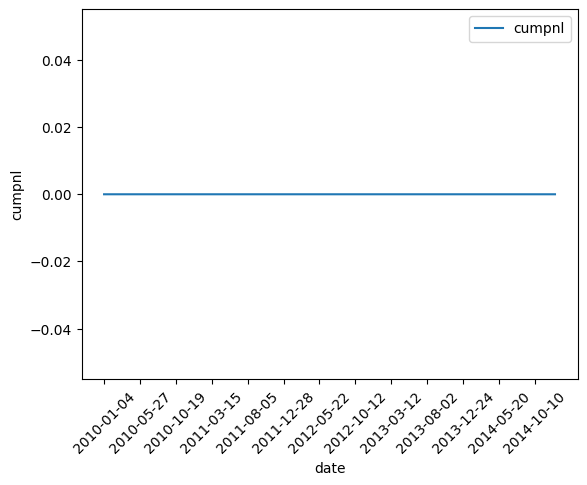

[0.0, 0.0, 0.0, 0.0, 0.0]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,NaN,0.0,0.0,0.0
1,2011,NaN,0.0,0.0,0.0
2,2012,NaN,0.0,0.0,0.0
3,2013,NaN,0.0,0.0,0.0
4,2014,NaN,0.0,0.0,0.0


In [18]:
alpha_2_data, alpha_2_cumpnl = AlphaStats(alpha_matrix2, close_df)
alpha_2_data.head()

In [19]:
test3(alpha_2_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


## The third strategy

$alpha = \frac{high-low}{close} + delta$

In [49]:
day_step = 5
delta = 0

In [50]:
def make_high_minus_low_ratio_close_alpha(high_df, low_df, close_df, n, delta):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros((close.shape))

    for i in range(n, close.shape[0]):
        alpha[i] = (high[i-1] - low[i-1]) / close[i-n] + delta

    return alpha

In [51]:
alpha_matrix3 = make_high_minus_low_ratio_close_alpha(high_df, low_df, close_df, day_step, delta)
print(alpha_matrix3.shape)

(1257, 2436)


In [52]:
alpha_matrix3, zeros_outliers = mpa.CutOutliers(alpha_matrix3, 3)
alpha_matrix3, zeros_middles = mpa.CutMiddle(alpha_matrix3, 7)
alpha_matrix3 = mpa.truncate_alpha(alpha_matrix3, 0.5)
# alpha_matrix3 = mpa.crop(alpha_matrix3, 0.1)
zeros_merged = merge_zeros(zeros_outliers, zeros_middles)

In [53]:
alpha_matrix3 = neutralize_with_dropout(alpha_matrix3, zeros_merged)
alpha_matrix3 = normalize(alpha_matrix3)

In [54]:
test1(alpha_matrix3)
test2(alpha_matrix3[day_step:])

Neutrality test passed
Normality test passed


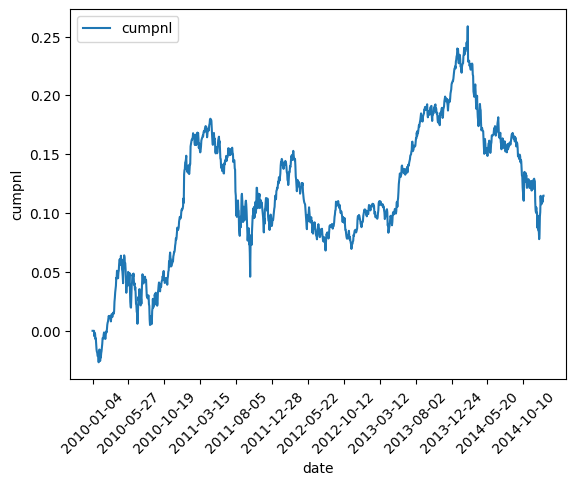

[0.103840976528332, 0.09398545228670938, 0.09244630994062565, 0.21237519651309278, 0.11483349423682741]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.451114,0.837644,0.059197,0.103841
1,2011,-0.100817,0.839243,0.134236,0.093985
2,2012,-0.030055,0.822309,0.084699,0.092446
3,2013,2.548089,0.838317,0.026853,0.212375
4,2014,-1.217587,0.757753,0.180886,0.114833


In [55]:
alpha_3_data, alpha_3_cumpnl = AlphaStats(alpha_matrix3, close_df)
alpha_3_data.head()

In [56]:
test3(alpha_3_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test not passed
passed 0 out of 3 tests


In [57]:
for alpha in alphas:
    print(alpha.name, ":\t", calc_alphas_corr(alpha.cumpnl, alpha_3_cumpnl))

alpha1 :	 0.6556672507275503


## The fourth strategy

**$alpha  = \frac{high}{low}$**

In [329]:
day_step = 5
delta = -1

In [330]:
def make_high_low_ratio_alpha(high_df, low_df, window, delta):
    
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T

    low = np.where(low == 0., 1e-12, low)

    alpha = np.zeros((high.shape))

    print(alpha.shape)

    for i in range(window, len(high)):
        alpha[i] += high[i-1] / low[i-window] + delta

    return alpha

In [331]:
alpha_matrix4 = make_high_low_ratio_alpha(high_df, low_df, day_step, delta)

(1257, 2436)


In [336]:
# alpha_matrix4 = decay(alpha_matrix4, 3)
alpha_matrix4, zeros_outliers = mpa.CutOutliers(alpha_matrix4, 5)
alpha_matrix4, zeros_middles = mpa.CutMiddle(alpha_matrix4, 7)
alpha_matrix4 = mpa.truncate_alpha(alpha_matrix4, 0.1)

zeros_merged = merge_zeros(zeros_outliers, zeros_middles)
alpha_matrix4 = neutralize_with_dropout(-alpha_matrix4, zeros_merged)
alpha_matrix4 = normalize(alpha_matrix4)

In [337]:
test1(alpha_matrix4)
test2(alpha_matrix4[day_step:])

Neutrality test passed
Normality test passed


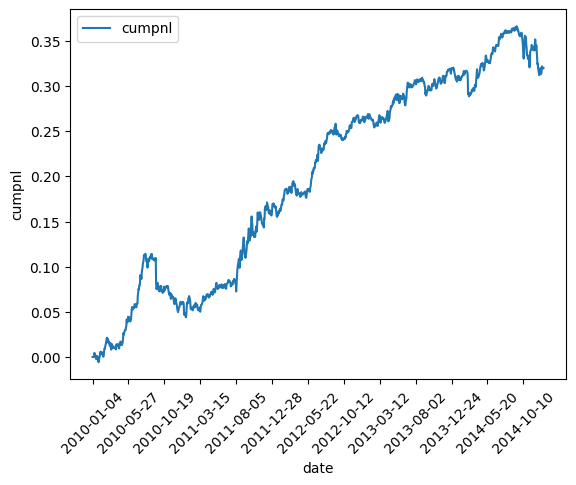

[0.06076426380139926, 0.16939227212887256, 0.263327559049348, 0.3194395789289166, 0.3202212855101604]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.202845,0.818833,0.064747,0.060764
1,2011,1.906235,0.859107,0.022877,0.169392
2,2012,2.473162,0.811304,0.018490,0.263328
3,2013,1.419811,0.802176,0.019786,0.319440
4,2014,0.015285,0.804357,0.054160,0.320221


In [338]:
alpha_4_data, alpha_4_cumpnl = AlphaStats(alpha_matrix4, close_df)
alpha_4_data.head()

In [339]:
test3(alpha_4_data)

Sharpe test passed
Turnover tets not passed
Cumpnl test passed
passed 2 out of 3 tests


In [340]:
for alpha in alphas:
    print(alpha.name, ":\t", calc_alphas_corr(alpha.cumpnl, alpha_4_cumpnl))

alpha1 :	 0.970429511646013


## The fifth strategy

$alpha = (high + low - 2close) / close$

In [67]:
day_step = 1
close_window = day_step
delta = 0

In [68]:
def make_alpha_the_fifth_way(high_df, low_df, close_df, window, window_cl, delta):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    close = np.where(close == 0., 1e-14, close)

    alpha = np.zeros((high.shape))

    for i in range(window, len(high)):
        alpha[i] += (high[i-window] + low[i-window] - 2*close[i-window]) / close[i-window_cl] + delta

    return alpha    

In [69]:
alpha_matrix5 = make_alpha_the_fifth_way(high_df, low_df, close_df, day_step, close_window, delta)
alpha_matrix5 = decay(alpha_matrix5, 3)

In [70]:
alpha_matrix5 = normalize(neutralize(alpha_matrix5))

In [71]:
# first four are zero
test1(alpha_matrix5)
test2(alpha_matrix5[4:])

Neutrality test passed
Normality test passed


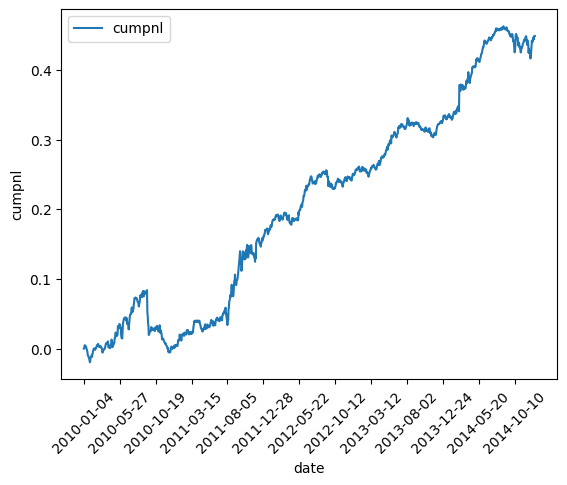

[0.0029698130273298766, 0.16219270679697007, 0.24883947645478677, 0.33289495167028854, 0.4486994727985196]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.048892,0.785424,0.089377,0.002970
1,2011,2.262974,0.782052,0.028149,0.162193
2,2012,2.146653,0.766652,0.026939,0.248839
3,2013,2.473542,0.772067,0.027631,0.332895
4,2014,1.873052,0.784055,0.046202,0.448699


In [72]:
alpha_5_data, alpha_5_cumpnl = AlphaStats(alpha_matrix5, close_df)
alpha_5_data.head()

In [73]:
test3(alpha_5_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [83]:
for alpha in alphas:
    print(alpha.name, ":\t", calc_alphas_corr(alpha.cumpnl, alpha_5_cumpnl))

alpha1 :	 0.9305486966148369


## The sixth strategy

$high \times low / close^2$

In [75]:
day_step = 5
cl_day_step = day_step
factor = 1
delta = 0

In [76]:
def make_sixth_strategy_alpha(high_df, low_df, close_df, window, cl_window, factor, delta):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros_like((close))

    for i in range(window, len(close)):
        alpha[i] = factor * high[i]*low[i] / close[i]**2 + delta

    return alpha

In [77]:
alpha_matrix6 = make_sixth_strategy_alpha(high_df, low_df, close_df, day_step, cl_day_step, factor, delta)

In [78]:
alpha_matrix6 = decay(alpha_matrix6, 5)
alpha_matrix6, zeros_outliers = mpa.CutOutliers(alpha_matrix6, 10)
alpha_matrix6 = neutralize_with_dropout(alpha_matrix6, zeros_outliers)

alpha_matrix6 = normalize(alpha_matrix6)

In [79]:
# test1(neutralize(alpha_matrix6))
test1(alpha_matrix6)
test2(alpha_matrix6[day_step:]) # the first is zero

Neutrality test passed
Normality test passed


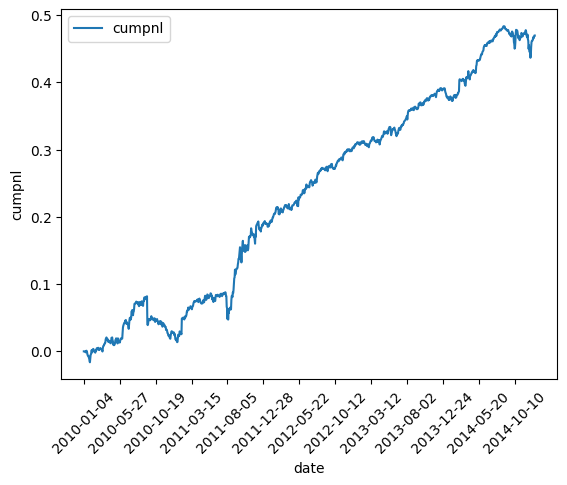

[0.028052840107062632, 0.1914226437812785, 0.3020182018066613, 0.390228074006115, 0.4697825134894237]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.480709,0.667183,0.063182,0.028053
1,2011,2.322993,0.680233,0.040691,0.191423
2,2012,3.289032,0.664682,0.010680,0.302018
3,2013,3.004424,0.670935,0.013804,0.390228
4,2014,1.633775,0.684969,0.046817,0.469783


In [80]:
alpha_6_data, alpha_6_cumpnl = AlphaStats(alpha_matrix6, close_df)
alpha_6_data.head()

In [81]:
test3(alpha_6_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [84]:
for alpha in alphas:
    print(alpha.name, ":\t", calc_alphas_corr(alpha.cumpnl, alpha_6_cumpnl))

alpha1 :	 0.9525808332807394


# The seventh strategy

$alpha = (high + low) / close \pm 1$

In [85]:
day_step=1
delta = -1

In [86]:
def make_high_low_close_ration_seventh_alpha(high_df, low_df, close_df, n, delta):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    _new_alpha_matrix = np.zeros((close.shape))

    for i in range(n, len(close)):
        _new_alpha_matrix[i] = (high[i-n] + low[i-n]) / close[i-1] + delta

    return _new_alpha_matrix

In [87]:
alpha_matrix7 = make_high_low_close_ration_seventh_alpha(high_df, low_df, close_df, day_step, delta)
alpha_matrix7 = normalize(neutralize(decay(alpha_matrix7, 5)))

test1(alpha_matrix7)
test2(alpha_matrix7[day_step:])

Neutrality test passed
Normality test passed


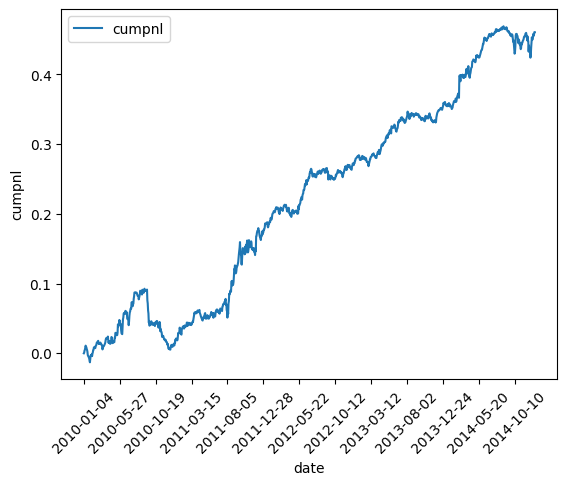

[0.013225261151225746, 0.17748325145068042, 0.27007475177007495, 0.35786986728305403, 0.46075455393490244]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.245776,0.649604,0.087355,0.013225
1,2011,2.390189,0.641220,0.032313,0.177483
2,2012,2.353910,0.624242,0.017411,0.270075
3,2013,2.635018,0.629688,0.015723,0.357870
4,2014,1.713215,0.639996,0.045008,0.460755


In [88]:
alpha_7_data, alpha_7_cumpnl = AlphaStats(alpha_matrix7, close_df)
alpha_7_data.head()

In [89]:
test3(alpha_7_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [90]:
for alpha in alphas:
    print(alpha.name, ":\t", calc_alphas_corr(alpha.cumpnl, alpha_7_cumpnl))

alpha1 :	 0.9391643772777148


# The eighth strategy

$alpha = open/close$

In [91]:
def make_open_close_ration_alpha(open_df, close_df):
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    close = np.where(close == 0., 1e-14, close)  #  можно применить фильтр выбросов

    alpha = open / close

    alpha = np.concatenate((np.zeros((1, alpha.shape[1])), alpha[:-1]))

    return alpha

In [92]:
alpha_matrix8 = make_open_close_ration_alpha(open_df, close_df)
alpha_matrix8 = normalize(neutralize(decay(alpha_matrix8, 4)))

In [93]:
test1(alpha_matrix8)
test2(alpha_matrix8[1:])  # the first is zero

Neutrality test passed
Normality test passed


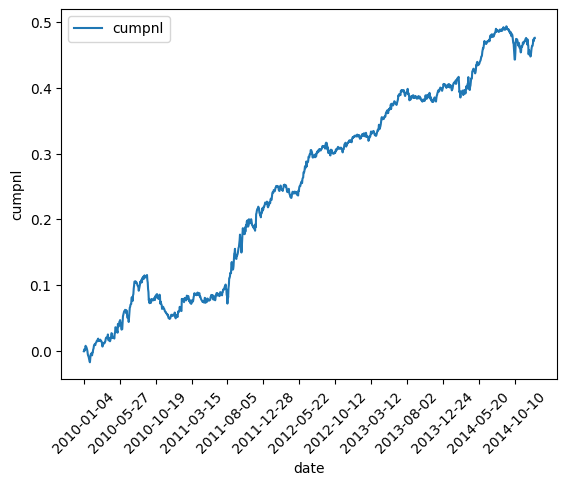

[0.05538023075762157, 0.21928064517661777, 0.32518874744458953, 0.4038497440272784, 0.4754959225779923]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.031744,0.729662,0.066717,0.055380
1,2011,2.374632,0.717823,0.028916,0.219281
2,2012,2.653975,0.712914,0.020291,0.325189
3,2013,2.131362,0.715731,0.019877,0.403850
4,2014,1.264289,0.722283,0.050510,0.475496


In [94]:
alpha_8_data, alpha_8_cumpnl = AlphaStats(alpha_matrix8, close_df)
alpha_8_data.head()

In [95]:
test3(alpha_8_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [97]:
for alpha in alphas:
    print(alpha.name, ":\t", calc_alphas_corr(alpha.cumpnl, alpha_8_cumpnl))

alpha1 :	 0.965181932593404


# The ninth strategy

$alpha = high / close$

In [98]:
def make_high_close_ratio_alpha(high_df, close_df):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    close = np.where(close == 0., 1e-14, close)  #  можно применить фильтр выбросов

    alpha = high / close

    alpha = np.concatenate((np.zeros((1, alpha.shape[1])), alpha[:-1]))

    return alpha

In [99]:
alpha_matrix9 = make_high_close_ratio_alpha(high_df, close_df)
alpha_matrix9 = normalize(neutralize(decay(alpha_matrix9, 3)))

In [100]:
test1(alpha_matrix9)
test2(alpha_matrix9[1:]) # the first is zero

Neutrality test passed
Normality test passed


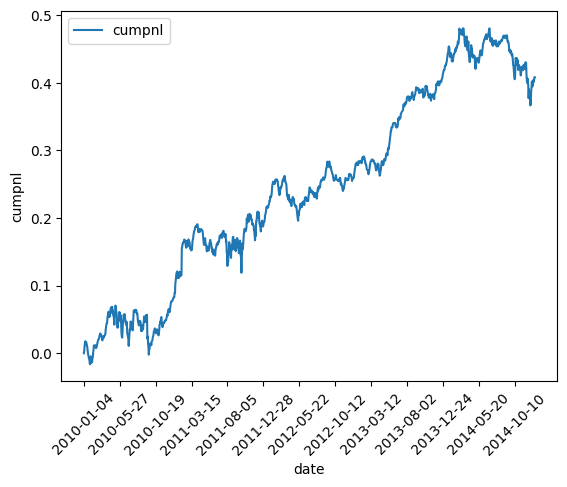

[0.08257171244127678, 0.19411216945753332, 0.25980797486286006, 0.41871490634912223, 0.40817023393152857]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.977550,0.490815,0.072633,0.082572
1,2011,1.089827,0.471074,0.071764,0.194112
2,2012,1.274664,0.463514,0.066260,0.259808
3,2013,3.339109,0.469423,0.028594,0.418715
4,2014,-0.127945,0.433352,0.114072,0.408170


In [101]:
alpha_9_data, alpha_9_cumpnl = AlphaStats(alpha_matrix9, close_df)
alpha_9_data.head()

In [102]:
test3(alpha_9_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [103]:
for alpha in alphas:
    print(alpha.name, ":\t", calc_alphas_corr(alpha.cumpnl, alpha_9_cumpnl))

alpha1 :	 0.9302009877072537


# The tenth strategy

$alpha = (close - low) / (high - low)$

In [104]:
def make_tenth_strategy_alpha(high_df, low_df, close_df):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    close_min_low = close - low
    high_min_low = high - low
    high_min_low = np.where(high_min_low == 0.0, 1e-14, high_min_low)

    alpha = - close_min_low / high_min_low

    alpha = np.concatenate((np.zeros((1, alpha.shape[1])), alpha[:-1]))

    return alpha

In [105]:
alpha_matrix10 = make_tenth_strategy_alpha(high_df, low_df, close_df)
alpha_matrix10 = normalize(neutralize(alpha_matrix10))

In [106]:
test1(alpha_matrix10)
test2(alpha_matrix10[1:]) # the first is null

Neutrality test passed
Normality test passed


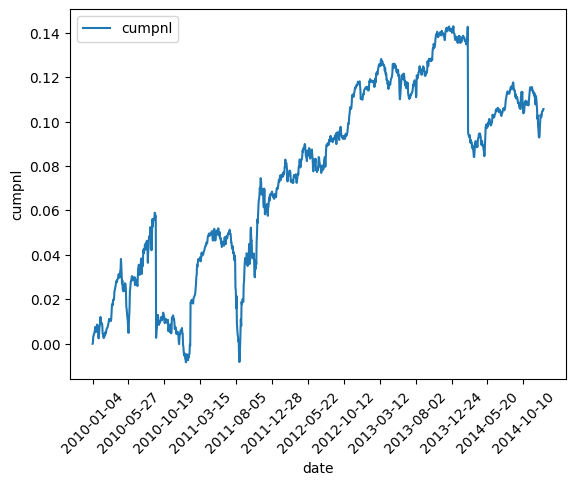

[0.004546366929331899, 0.06654502490069641, 0.10981393578483299, 0.14120436478413723, 0.10558799166862848]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.069740,1.314477,0.059115,0.004546
1,2011,1.221992,1.317017,0.060159,0.066545
2,2012,1.725020,1.296326,0.013001,0.109814
3,2013,1.328577,1.296003,0.018138,0.141204
4,2014,-0.667149,1.305958,0.058835,0.105588


In [107]:
alpha_10_data, alpha_10_cumpnl = AlphaStats(alpha_matrix10, close_df)
alpha_10_data.head()

In [108]:
test3(alpha_10_data)

Sharpe test passed
Turnover tets not passed
Cumpnl test not passed
passed 1 out of 3 tests


In [109]:
for alpha in alphas:
    print(alpha.name, ":\t", calc_alphas_corr(alpha.cumpnl, alpha_10_cumpnl))

alpha1 :	 0.9185314602992911


# The eleventh strategy

$alpha = (close - low) / (high - low) < 0.5$ Нужно решить какой знак

In [ ]:
def make_alpha_eleventh(close_df, low_df, high_df):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    close_min_low = close - low
    high_min_low = high - low
    high_min_low = np.where(high_min_low == 0.0, 1e-14, high_min_low)

    alpha = close_min_low / high_min_low
    alpha = neutralize(np.where(alpha < 0.5, alpha, 0))
    alpha = np.concatenate((np.zeros((1, alpha.shape[1])), normalize(alpha[:-1])))
    
    return alpha

In [ ]:
alpha_matrix11 = make_alpha_eleventh(close_df, low_df, high_df)

test1(alpha_matrix11)
test2(alpha_matrix11[1:])

In [ ]:
def count_instruments_volatility (instruments_incomes):
    
    def std (vector):
        return np.sqrt(np.sum((vector - vector.mean())**2) / (len(vector) - 1))

    # транспонируем матрицу доходностей, потому что сейчас каждая строка - это 
    # доходность каждого инструмента в конкретный день
    volatility = np.array([std(vector) for vector in instruments_incomes.T]) 

    return volatility

In [ ]:
volatility_by_instrument = count_instruments_volatility(instrument_return(close_df))
print(volatility_by_instrument.shape)

indexes = np.argsort(volatility_by_instrument)
print(volatility_by_instrument[indexes][0:10])
plt.plot(np.arange(1, len(indexes)+1), volatility_by_instrument[indexes], label='sorted', color='red')
# plt.plot(volatility_by_instrument, label='not sorted', color='blue')
plt.legend()
plt.show()

In [ ]:
alpha_11_data, alpha_11_cumpnl = AlphaStats(alpha_matrix11, close_df)
alpha_11_data.head()

In [ ]:
test3(alpha_11_data)

# The twelveth strategy
$alpha = ts\_correlation(volume, close)$

# Alphas from Kakushadze

## Mean-reversion alpha

$-ln\frac{open(d)}{close(d-1)}$

In [206]:
day_step = 5

In [207]:
def make_mean_reversion_alpha(close_df, open_df, day_step):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    alpha = -np.log(open[day_step:] / close[:-day_step])
    return np.concatenate((np.zeros((day_step, alpha.shape[1])), alpha))

In [214]:
mean_reversion_alpha = make_mean_reversion_alpha(close_df, open_df, day_step)

# mean_reversion_alpha, zeros_outliers = mpa.CutOutliers(mean_reversion_alpha, 1)
# mean_reversion_alpha, zeros_middles = mpa.CutMiddle(mean_reversion_alpha, 10)

# mean_reversion_alpha = mpa.truncate_alpha(mean_reversion_alpha, 0.05)
# mean_reversion_alpha = decay(mean_reversion_alpha, 10)

# mean_reversion_alpha = mpa.crop(mean_reversion_alpha, 0.1)
# zeros_merged = merge_zeros(zeros_outliers, zeros_middles) 

# mean_reversion_alpha = neutralize_with_dropout(mean_reversion_alpha, zeros_outliers)
# mean_reversion_alpha = neutralize_with_dropout(mean_reversion_alpha,zeros_middles)

mean_reversion_alpha = neutralize(mean_reversion_alpha)
mean_reversion_alpha = normalize(mean_reversion_alpha)

In [215]:
test1(mean_reversion_alpha)
test2(mean_reversion_alpha[day_step:])

Neutrality test passed
Normality test passed


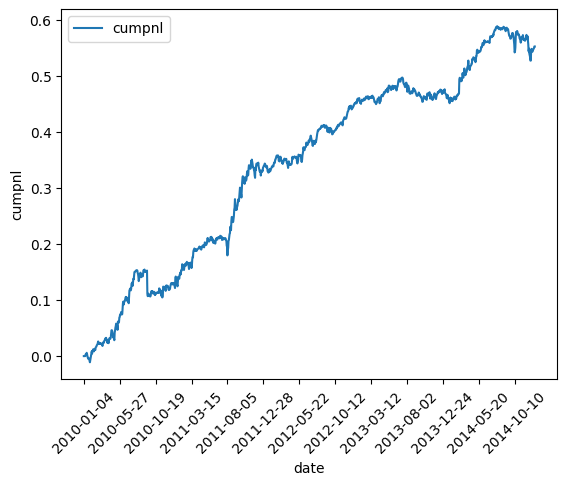

[0.13013280477519074, 0.3397833709379966, 0.4478529330706973, 0.4751585233529981, 0.5534736520708535]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.826766,0.703284,0.049820,0.130133
1,2011,2.661697,0.715459,0.035109,0.339783
2,2012,2.382048,0.712227,0.022373,0.447853
3,2013,0.601442,0.706987,0.043365,0.475159
4,2014,1.197006,0.704996,0.061401,0.553474


In [216]:
mean_rev_alpha_data, mean_rev_alpha_cumpnl = AlphaStats(mean_reversion_alpha, close_df)
mean_rev_alpha_data.head()

In [217]:
test3(mean_rev_alpha_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [218]:
alphas.append(Alphas_Data('mean_reverse', mean_rev_alpha_cumpnl))

## Momentum alpha

$ln\frac{close(d-1)}{open(d-1)}$

In [219]:
def make_momentum_alpha(close_df, open_df, day_step):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    alpha = -np.log(close[day_step:] / open[day_step:])
    return np.concatenate((np.zeros((day_step, alpha.shape[1])), alpha))

In [270]:
day_step = 1

momentum_alpha = make_momentum_alpha(close_df, open_df, day_step)
# momentum_alpha, zeros_outliers = mpa.CutOutliers(momentum_alpha, 10)
# momentum_alpha = mpa.truncate_alpha(momentum_alpha, 0.01)
momentum_alpha = decay(momentum_alpha, 10)

# mean_reversion_alpha = neutralize_with_dropout(mean_reversion_alpha, zeros_outliers)
momentum_alpha = neutralize(momentum_alpha)
momentum_alpha = normalize(momentum_alpha)

In [271]:
test1(momentum_alpha)
test2(momentum_alpha[day_step:])

Neutrality test passed
Normality test passed


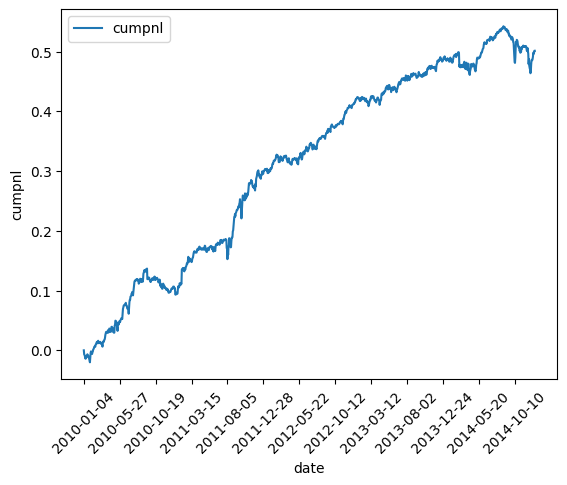

[0.10661293792031856, 0.3002020191697033, 0.41216837396106537, 0.4888151010074261, 0.5013727770371479]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,2.039785,0.525302,0.040283,0.106613
1,2011,2.744481,0.485311,0.033744,0.300202
2,2012,2.879972,0.477292,0.016937,0.412168
3,2013,1.992797,0.479547,0.015440,0.488815
4,2014,0.199084,0.487745,0.078618,0.501373


In [272]:
momentum_alpha_data, momentum_alpha_cumpnl = AlphaStats(momentum_alpha, close_df)
momentum_alpha_data.head()

In [273]:
test3(momentum_alpha_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [274]:
for alpha in alphas:
    print(f'{alpha.name}:\t{calc_alphas_corr(alpha.cumpnl, momentum_alpha_cumpnl)}')

mean_reverse:	0.9926339585133639


## Alpha 1

(rank(Ts_ArgMax(SignedPower(((returns < 0) ? stddev(returns, 20) : close), 2.), 5)) - 0.5)